In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import variational_autoencoder as vae
import weapon_data as weapons

from tensorflow.python.framework import random_seed

import matplotlib.pyplot as plt
%matplotlib inline

class tfPlugin:
    def onSetup(self):
        self._random_seed = 19071991
        seed, _ = random_seed.get_seed(self._random_seed)
        np.random.seed(seed)
        
        self.shouldStop = False
        
        self._train_data, self._test_data = weapons.get_data(2, 14, 0, seed=self._random_seed)

        #set training parameter
        self._network_architecture = \
            dict(n_input=self._train_data.num_features,
                 n_hidden_1=26,
                 n_hidden_2=12,
                 n_z=2)  
        self._batch_size = 4
        self._learning_rate = 0.01
        self._optimizer = tf.train.RMSPropOptimizer(self._learning_rate)
        self._transfer_fct = tf.nn.elu
        self._num_training_epochs = 70
        
        #keep track of the received and dismantled weapons 
        self._dismantled_weapons = []
        
        #amount of dismantles models needed to retrain the model
        self._dismantled_weapons_needed_to_retrain = 20
        
        #start session is realized in on begin training and will be swaped with the tmp afterwards
        self._sess = None
        self._vae = None
        
        self._trained_model_available = False
        self._trained_model_path = ""
        
    def onJsonInput(self, jsonInput):
        if self._trained_model_available:
            self.__load_trained_model()
            
        if self._vae == None:
            print("ERROR: there is no trained model?!")
            return {}
        
        if not bool(jsonInput):
            print("ERROR: empty input!")
            return {}
        
        generated_weapon = []
        
        #encode the json input to a standardized weapon data
        encoded_json_input = self.__encode_json_input_to_a_standardized_train_data_format(jsonInput)
        #check if the encoded data should be used to generate a new one 
        #calculate loss requires a batch which has the size of the trained model batch_size
        batch = [encoded_json_input[0] for _ in range(self._batch_size)]
        generation_cost = self._vae.calculate_loss(batch)
        generation_cost /= self._batch_size

        #if the cost is too high, then just generate a random one
        #a too high value means that the VAE don't know which weapon that should be!
        if generation_cost >= 50 or np.isnan(generation_cost) or np.isinf(generation_cost):
            generated_weapon = self.__generate_random_weapons(1)
            print("Generated a random weapon!")
        else:
            generated_weapon = self._vae.encode_and_decode(encoded_json_input, False)
            print("Generated a new weapon based on a dismantled one!")

        if len(generated_weapon) <= 0:
            print("ERROR: no generated weapon?!")
            return {}
        
        #do it afterwards so that crazy weapons don't destroy the model
        self.__add_received_dismantled_weapon(encoded_json_input[0])
        
        result, _ = self._train_data.decode_processed_tensor(generated_weapon[0])
        return result
        
    def onBeginTraining(self):
        with tf.Session() as sess:

            #add the dismantled weapons so that the model emerges in a direction
            if len(self._dismantled_weapons) > 0:
                self._train_data.add_new_weapons_and_restandardize_data(self._dismantled_weapons)
                self._dismantled_weapons = []
                self._num_training_epochs += 10

            network = vae.get_untrained(sess, self._network_architecture, self._optimizer, 
                                      self._transfer_fct, self._batch_size)

            num_samples = self._train_data.num_examples
            print("Num of training samples = %i" %num_samples)
            
            #is basically the same code from the VAE file
            #training cycle
            for epoch in range(self._num_training_epochs):
                avg_cost = 0.
                total_batch = int(num_samples / self._batch_size)

                # Loop over all batches
                for _ in range(total_batch):
                    batch = self._train_data.next_batch(self._batch_size)

                    # Fit training using batch data
                    cost = network.train_with_mini_batch(batch)

                    #compute average loss/cost
                    avg_cost += cost / num_samples * self._batch_size

                # Display logs per epoch step
                if epoch % 10 == 0:
                    print("Epoch:"+ '%04d' % (epoch) + " - Cost:" + "{:.2f}".format(avg_cost))

                if self.shouldStop:
                    break;

            self._trained_model_path = network.save_trained_model("./vae_model/")
            self._trained_model_available = True
        
        
    def onStopTraining(self):
        if self._sess:
            self._sess.close()
        
    def __load_trained_model(self):
        if self._sess:
            self._sess.close()
        tf.reset_default_graph()
    
        self._sess = tf.Session(graph=tf.get_default_graph())
        self._vae = vae.get_untrained(self._sess, self._network_architecture, self._optimizer, 
                                  self._transfer_fct, self._batch_size)
        self._vae = vae.restore(self._vae, self._trained_model_path)
        self._trained_model_available = False
        
    def __encode_json_input_to_a_standardized_train_data_format(self, json_input):
        prepared_for_encoding = self._train_data.prepare_decoded_tensor_dict_for_encoding(json_input)
        encoded, _ = self._train_data.encode_features_dict(prepared_for_encoding)
        encoded_standardized = self._train_data.standardize_encoded_data(encoded[0])
        return [encoded_standardized]
    
    def __add_received_dismantled_weapon(self, weapon):
        self._dismantled_weapons.append(weapon)
        
        if len(self._dismantled_weapons) >= self._dismantled_weapons_needed_to_retrain:
            self.shouldRetrain = True
            print("Should retrain!")
    
    def __generate_random_weapons(self, num):
        generated_weapons = []
        
        for _ in range(num):
            random_val = np.random.normal(size=(1, self._network_architecture["n_z"]))
            weapons = self._vae.decode_from_latent_space(random_val, False)
            [generated_weapons.append(weapon) for weapon in weapons]
            
        return generated_weapons
    
    def __print_decoded_tensors_as_dict(self, array_of_tensors):
        genDict = {}

        for tensor in array_of_tensors:
            decoded, _ = weapon_data.decode_processed_tensor(tensor)

            for key, value in decoded.items():
                if key not in genDict:
                    genDict[key] = []
                genDict[key].append(value)

        for key, value in genDict.items():
                print(key, "=", value)
                
    def show_z_distribution(self, title, z_mean=True):
        all_z = np.zeros((self._batch_size,self._network_architecture['n_z']))

        total_batch = int(self._train_data.num_examples / self._batch_size) 

        # Loop over all batches
        for i in range(total_batch):
            batch = self._train_data.next_batch(self._batch_size)
            z_dist = self._vae.calculate_z(batch)
            if z_mean:
                z_dist = self._vae.calculate_z_mean(batch)
            all_z = np.vstack((all_z, z_dist))

        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.scatter(all_z[:,0], all_z[:,1])
        plt.xlim(-3,3)
        plt.ylim(-3,3)
        plt.title(title)
        plt.subplot(1,2,2)
        plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
        plt.colorbar()
        plt.title(title)


D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Num of training samples = 127
Epoch:0000 - Cost:23.96
Epoch:0010 - Cost:12.09
Epoch:0020 - Cost:11.82
Epoch:0030 - Cost:10.57
Epoch:0040 - Cost:10.03
Epoch:0050 - Cost:8.83
Epoch:0060 - Cost:9.36
INFO:tensorflow:Restoring parameters from ./vae/model.ckpt
ERROR: empty input!


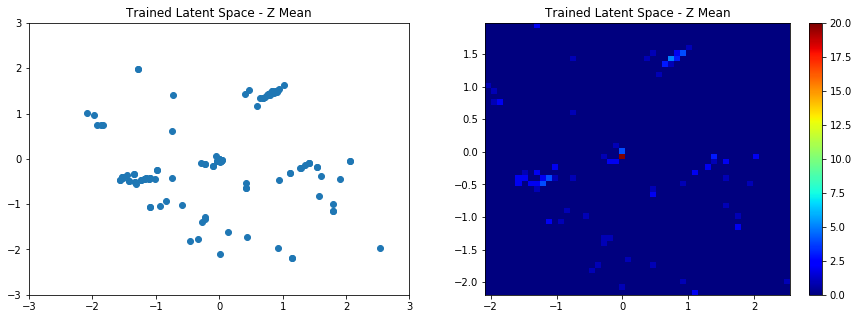

In [2]:
pluginTest = tfPlugin()
pluginTest.onSetup()
pluginTest.onBeginTraining()
pluginTest.onJsonInput({})
pluginTest.show_z_distribution("Trained Latent Space - Z Mean", z_mean=True)

In [3]:
json_test = {'damages_first': '102.5',
 'damages_last': '6.25',
 'dmg_distances_first': '14.0',
 'dmg_distances_last': '21.0',
 'firemode_Automatic': '0.0',
 'firemode_Semi-Automatic': '0.0',
 'hiprecoildec': '6.0',
 'hiprecoilright': '1.2000000476837158',
 'hiprecoilup': '11.0',
 'hipstandbasespreaddec': '4.5',
 'hipstandbasespreadinc': '0.30000001192092896',
 'hordispersion': '2.700000047683716',
 'initialspeed': '333.0',
 'magsize': '2.0',
 'reloadempty': '5.333333492279053',
 'rof': '299.0',
 'shotspershell': '12.0',
 'type_Pistol': '0.0',
 'type_Rifle': '-2.7755575615628914e-17',
 'type_Shotgun': '1.0',
 'type_Sniper Rifle': '0.0',
 'type_Submachine Gun': '0.0'}

def input_and_train():
    global pluginTest, json_test
    for _ in range(pluginTest._dismantled_weapons_needed_to_retrain):
        for key, value in json_test.items():
            if "type" not in key or "firemode" not in key:
                new_value = float(value) * np.random.uniform(low=0.8, high=1.2)
                json_test[key] = str(new_value)
        pluginTest.onJsonInput(json_test)
    pluginTest.onBeginTraining()
    pluginTest.show_z_distribution("Trained Latent Space - Z Mean", z_mean=True)

Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a random weapon!
Generated a random weapon!
Generated a new weapon based on a dismantled one!
Generated a random weapon!
Generated a random weapon!
Generated a random weapon!
Generated a new weapon based on a dismantled one!
Generated a random weapon!
Generated a random weapon!
Generated a random weapon!
Generated a random weapon!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a random weapon!
Should retrain!
Num of training samples = 147
Epoch:0000 - Cost:23.15
Epoch:0010 - Cost:12.39
Epoch:0020 - Cost:10.84
Epoch:0030 - Cost:10.21
Epoch:0040 - Cost:10.22
Epoch:0050 - Cost:10.06
Epoch:0060 - Cost:9.49
Epoch:0070 - Cost

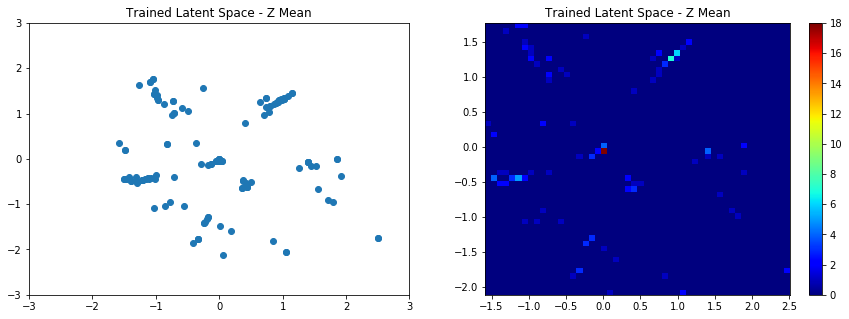

In [4]:
input_and_train()

INFO:tensorflow:Restoring parameters from ./vae/model.ckpt
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismant

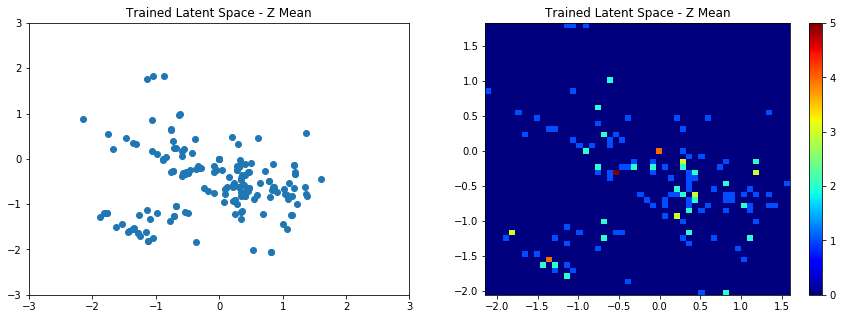

In [5]:
input_and_train()

INFO:tensorflow:Restoring parameters from ./vae/model.ckpt
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismant

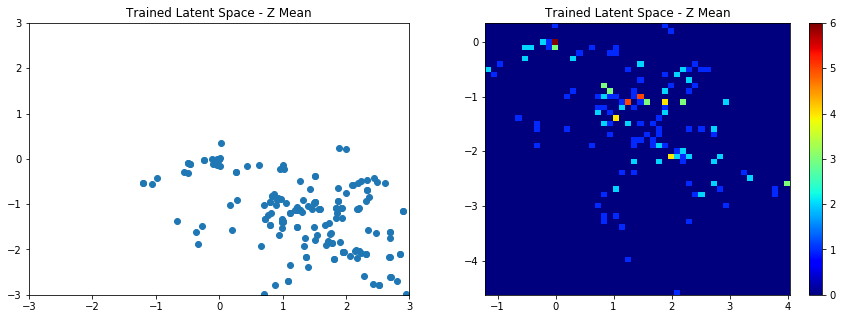

In [6]:
input_and_train()

INFO:tensorflow:Restoring parameters from ./vae/model.ckpt
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismant

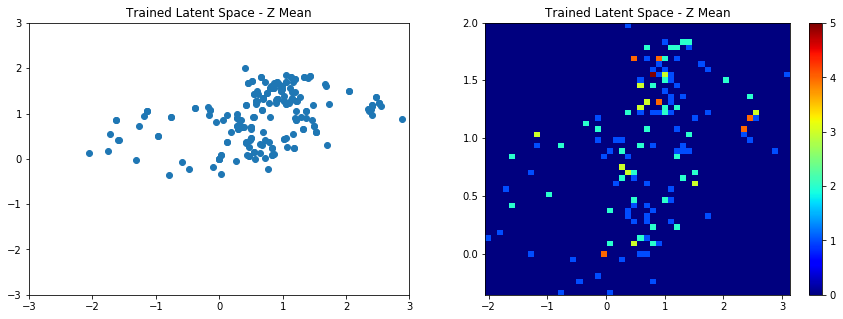

In [7]:
input_and_train()

INFO:tensorflow:Restoring parameters from ./vae/model.ckpt
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismant

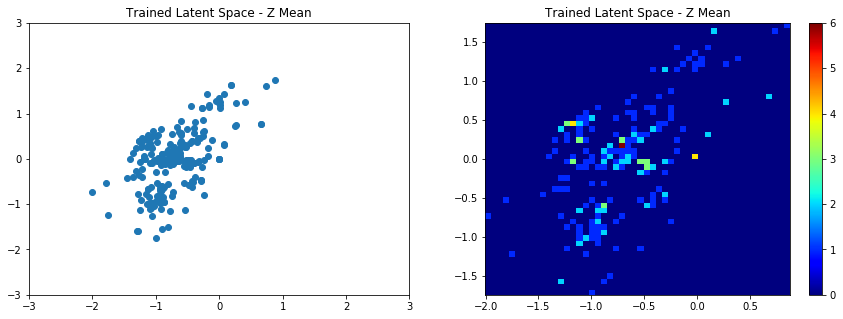

In [8]:
input_and_train()

INFO:tensorflow:Restoring parameters from ./vae/model.ckpt
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismant

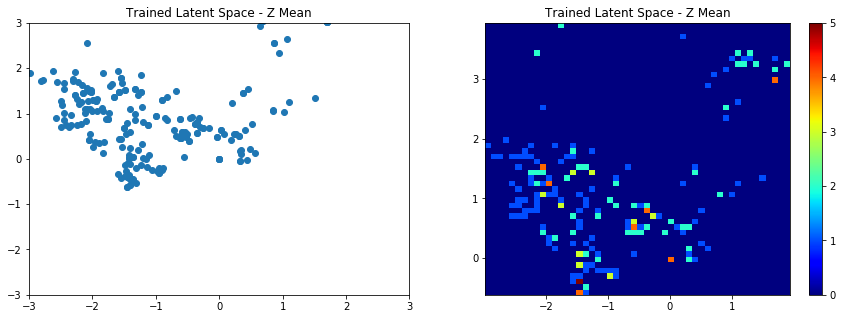

In [9]:
input_and_train()

INFO:tensorflow:Restoring parameters from ./vae/model.ckpt
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismant

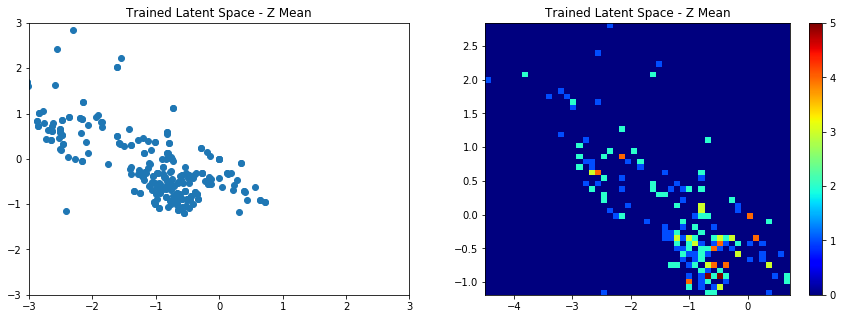

In [10]:
input_and_train()

INFO:tensorflow:Restoring parameters from ./vae/model.ckpt
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismant

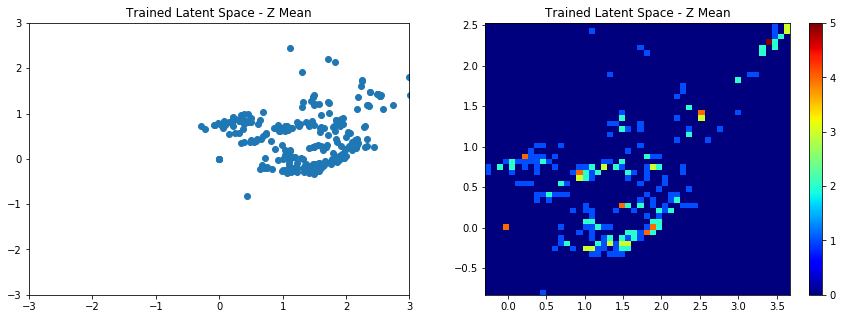

In [11]:
input_and_train()

INFO:tensorflow:Restoring parameters from ./vae/model.ckpt
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismant

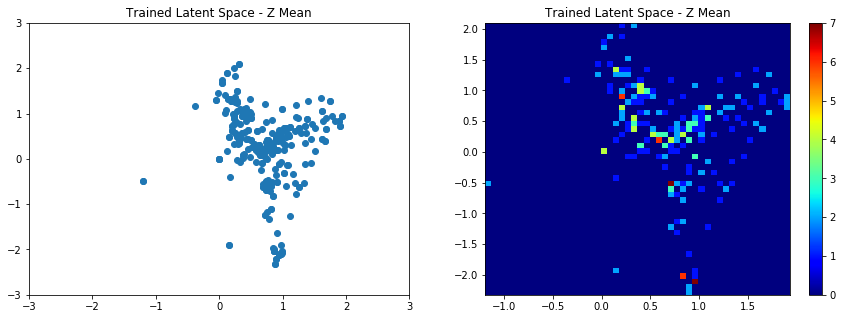

In [12]:
input_and_train()

INFO:tensorflow:Restoring parameters from ./vae/model.ckpt
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismantled one!
Generated a new weapon based on a dismant

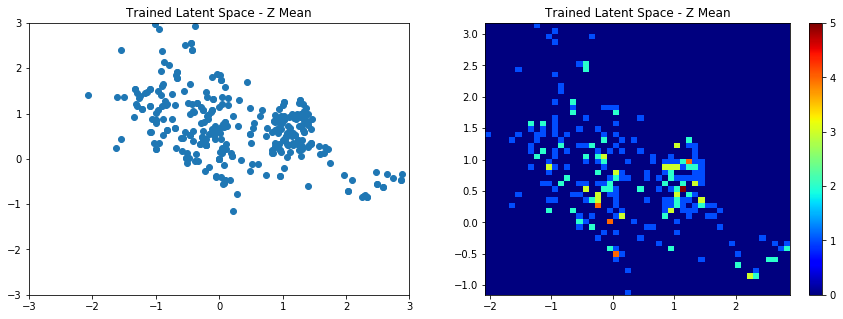

In [13]:
input_and_train()

In [14]:
pluginTest.onJsonInput(json_test)

INFO:tensorflow:Restoring parameters from ./vae/model.ckpt
Generated a new weapon based on a dismantled one!


{'damages_first': '91.638813017942',
 'damages_last': '34.54089823147545',
 'dmg_distances_first': '16.312232619368068',
 'dmg_distances_last': '65.08217054567481',
 'firemode_Automatic': '0.36953105875278147',
 'firemode_Semi-Automatic': '0.39047122543902585',
 'hiprecoildec': '5.446341082344819',
 'hiprecoilright': '2.033348553268505',
 'hiprecoilup': '11.714662600192458',
 'hipstandbasespreaddec': '10.712812187132908',
 'hipstandbasespreadinc': '0.5408897327144925',
 'initialspeed': '531.1499345221767',
 'magsize': '26.77106594071921',
 'reloadempty': '5.353924268387824',
 'rof': '309.60608621988365',
 'shotspershell': '21.6235450920789',
 'type_Pistol': '0.26579277970623116',
 'type_Rifle': '0.6387216131988911',
 'type_Shotgun': '0.16616065956709766',
 'type_Sniper Rifle': '0.28443794889896823',
 'type_Submachine Gun': '0.1899251459383272'}